In [ ]:
#图像增强
# 模型定义
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt
import numpy as np
from tqdm import *

# 设置设备
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# CIFAR-10的类别
classes = ('airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 定义VGG网络配置
cfg = {
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
}

# 定义VGG网络类
class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(256, 64),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )
        self._initialize_weights()
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


/home/ma-user/anaconda3/envs/PyTorch-1.8.2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


使用设备: cuda:0


In [2]:

# 添加充足的图像增强方法
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),           # 随机裁剪，加上padding=4
    transforms.RandomHorizontalFlip(),              # 随机水平翻转
    transforms.RandomRotation(15),                  # 随机旋转，角度范围±15度
    transforms.ColorJitter(                         # 颜色抖动
        brightness=0.2,                             # 亮度调整范围
        contrast=0.2,                               # 对比度调整范围
        saturation=0.2,                             # 饱和度调整范围
        hue=0.1                                     # 色调调整范围
    ),
    transforms.RandomAffine(                        # 随机仿射变换
        degrees=0,                                  # 不额外旋转
        translate=(0.1, 0.1),                       # 平移范围
        scale=(0.9, 1.1),                           # 缩放范围
    ),
    transforms.ToTensor(),                          # 先转换为Tensor
    transforms.Normalize(                           # 然后标准化
        (0.4914, 0.4822, 0.4465), 
        (0.2023, 0.1994, 0.2010)
    ),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.2)), # 最后应用随机遮挡
])

# 测试集不使用数据增强
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.4914, 0.4822, 0.4465), 
        (0.2023, 0.1994, 0.2010)
    ),
])

# 加载CIFAR-10数据集
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=8
)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=128, shuffle=False, num_workers=8
)

# 训练模型

def train_model(model, trainloader, testloader, criterion, optimizer, scheduler, epochs,history):
    
    best_acc = 0
    
    for epoch in range(1, epochs + 1):
        # 获取当前学习率
        current_lr = optimizer.param_groups[0]['lr']
        history['lrs'].append(current_lr)
        
        print(f'\n第 {epoch} 轮训练 (学习率 = {current_lr:.6f})')
        
        # 训练阶段
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        loop = tqdm(trainloader, total=len(trainloader), 
                   desc=f'训练: Epoch [{epoch}/{epochs}]')
        
        for batch_idx, (inputs, targets) in enumerate(loop):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            loop.set_postfix(loss=train_loss/(batch_idx+1), acc=100.*correct/total)
        
        # 计算训练结果
        train_epoch_loss = train_loss / len(trainloader)
        train_epoch_acc = 100. * correct / total
        history['train_losses'].append(train_epoch_loss)
        history['train_accs'].append(train_epoch_acc)
        
        # 测试阶段
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
  
            test_loop = tqdm(testloader, total=len(testloader), desc='测试:')
            for batch_idx, (inputs, targets) in enumerate(test_loop):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        
        # 计算测试结果
        test_epoch_loss = test_loss / len(testloader)
        test_epoch_acc = 100. * correct / total
        history['test_losses'].append(test_epoch_loss)
        history['test_accs'].append(test_epoch_acc)
        
        print(f'测试 | 损失: {test_epoch_loss:.3f} | 准确率: {test_epoch_acc:.3f}%')
        
        # 保存最佳模型
        if test_epoch_acc > best_acc:
            best_acc = test_epoch_acc
            torch.save(model.state_dict(), 'cifar10_vgg13_best.pth')
            print(f'Best model saved with accuracy: {best_acc:.2f}%')
        
        # 更新学习率调度器
        scheduler.step(test_epoch_acc)
    
    # 训练完成，保存最终模型
    torch.save(model.state_dict(), 'cifar10_vgg13_final.pth')
    print('Final model saved!')
    
    return model, history


model = VGG('VGG13')  # 创建VGG-13模型
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# 创建ReduceLROnPlateau学习率调度器
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=5, verbose=True
)

# 记录训练历史
history = {
    'train_losses': [],
    'train_accs': [],
    'test_losses': [],
    'test_accs': [],
    'lrs': []
}


Files already downloaded and verified
Files already downloaded and verified


In [3]:

# 训练循环
epochs = 100

# 执行训练
model, history = train_model(model, trainloader, testloader, criterion, optimizer, scheduler, epochs, history)



第 1 轮训练 (学习率 = 0.010000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.36it/s]


测试 | 损失: 1.888 | 准确率: 19.740%
Best model saved with accuracy: 19.74%

第 2 轮训练 (学习率 = 0.010000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.91it/s]


测试 | 损失: 1.640 | 准确率: 31.700%
Best model saved with accuracy: 31.70%

第 3 轮训练 (学习率 = 0.010000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.28it/s]


测试 | 损失: 1.613 | 准确率: 38.490%
Best model saved with accuracy: 38.49%

第 4 轮训练 (学习率 = 0.010000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 42.85it/s]


测试 | 损失: 1.237 | 准确率: 54.830%
Best model saved with accuracy: 54.83%

第 5 轮训练 (学习率 = 0.010000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.53it/s]


测试 | 损失: 1.229 | 准确率: 57.560%
Best model saved with accuracy: 57.56%

第 6 轮训练 (学习率 = 0.010000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.44it/s]


测试 | 损失: 0.985 | 准确率: 64.020%
Best model saved with accuracy: 64.02%

第 7 轮训练 (学习率 = 0.010000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.75it/s]


测试 | 损失: 0.902 | 准确率: 68.610%
Best model saved with accuracy: 68.61%

第 8 轮训练 (学习率 = 0.010000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.57it/s]


测试 | 损失: 0.874 | 准确率: 69.030%
Best model saved with accuracy: 69.03%

第 9 轮训练 (学习率 = 0.010000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.60it/s]


测试 | 损失: 0.813 | 准确率: 72.790%
Best model saved with accuracy: 72.79%

第 10 轮训练 (学习率 = 0.010000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 42.86it/s]


测试 | 损失: 0.845 | 准确率: 71.480%

第 11 轮训练 (学习率 = 0.010000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.43it/s]


测试 | 损失: 0.735 | 准确率: 73.690%
Best model saved with accuracy: 73.69%

第 12 轮训练 (学习率 = 0.010000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.40it/s]


测试 | 损失: 0.703 | 准确率: 76.790%
Best model saved with accuracy: 76.79%

第 13 轮训练 (学习率 = 0.010000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.28it/s]


测试 | 损失: 0.676 | 准确率: 77.060%
Best model saved with accuracy: 77.06%

第 14 轮训练 (学习率 = 0.010000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.92it/s]


测试 | 损失: 0.618 | 准确率: 79.240%
Best model saved with accuracy: 79.24%

第 15 轮训练 (学习率 = 0.010000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 44.48it/s]


测试 | 损失: 0.628 | 准确率: 79.740%
Best model saved with accuracy: 79.74%

第 16 轮训练 (学习率 = 0.010000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.46it/s]


测试 | 损失: 0.618 | 准确率: 79.540%

第 17 轮训练 (学习率 = 0.010000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.12it/s]


测试 | 损失: 0.537 | 准确率: 82.240%
Best model saved with accuracy: 82.24%

第 18 轮训练 (学习率 = 0.010000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.88it/s]


测试 | 损失: 0.552 | 准确率: 81.530%

第 19 轮训练 (学习率 = 0.010000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.79it/s]


测试 | 损失: 0.526 | 准确率: 82.840%
Best model saved with accuracy: 82.84%

第 20 轮训练 (学习率 = 0.010000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 42.95it/s]


测试 | 损失: 0.606 | 准确率: 80.450%

第 21 轮训练 (学习率 = 0.010000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.41it/s]


测试 | 损失: 0.509 | 准确率: 83.230%
Best model saved with accuracy: 83.23%

第 22 轮训练 (学习率 = 0.010000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.27it/s]


测试 | 损失: 0.490 | 准确率: 83.730%
Best model saved with accuracy: 83.73%

第 23 轮训练 (学习率 = 0.010000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.60it/s]


测试 | 损失: 0.523 | 准确率: 82.400%

第 24 轮训练 (学习率 = 0.010000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.51it/s]


测试 | 损失: 0.501 | 准确率: 83.710%

第 25 轮训练 (学习率 = 0.010000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.27it/s]


测试 | 损失: 0.470 | 准确率: 84.480%
Best model saved with accuracy: 84.48%

第 26 轮训练 (学习率 = 0.010000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.55it/s]


测试 | 损失: 0.468 | 准确率: 84.630%
Best model saved with accuracy: 84.63%

第 27 轮训练 (学习率 = 0.010000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 44.09it/s]


测试 | 损失: 0.527 | 准确率: 82.490%

第 28 轮训练 (学习率 = 0.010000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.47it/s]


测试 | 损失: 0.474 | 准确率: 84.350%

第 29 轮训练 (学习率 = 0.010000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 44.20it/s]


测试 | 损失: 0.469 | 准确率: 84.360%

第 30 轮训练 (学习率 = 0.010000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.35it/s]


测试 | 损失: 0.515 | 准确率: 83.430%

第 31 轮训练 (学习率 = 0.010000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.42it/s]


测试 | 损失: 0.425 | 准确率: 85.860%
Best model saved with accuracy: 85.86%

第 32 轮训练 (学习率 = 0.010000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.85it/s]


测试 | 损失: 0.398 | 准确率: 86.750%
Best model saved with accuracy: 86.75%

第 33 轮训练 (学习率 = 0.010000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.96it/s]


测试 | 损失: 0.410 | 准确率: 86.340%

第 34 轮训练 (学习率 = 0.010000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.06it/s]


测试 | 损失: 0.389 | 准确率: 87.220%
Best model saved with accuracy: 87.22%

第 35 轮训练 (学习率 = 0.010000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.47it/s]


测试 | 损失: 0.418 | 准确率: 86.370%

第 36 轮训练 (学习率 = 0.010000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 44.01it/s]


测试 | 损失: 0.408 | 准确率: 86.550%

第 37 轮训练 (学习率 = 0.010000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.33it/s]


测试 | 损失: 0.397 | 准确率: 87.080%

第 38 轮训练 (学习率 = 0.010000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.81it/s]


测试 | 损失: 0.416 | 准确率: 86.190%

第 39 轮训练 (学习率 = 0.010000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.78it/s]


测试 | 损失: 0.381 | 准确率: 86.960%

第 40 轮训练 (学习率 = 0.010000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.30it/s]


测试 | 损失: 0.408 | 准确率: 86.710%
Epoch    40: reducing learning rate of group 0 to 1.0000e-03.

第 41 轮训练 (学习率 = 0.001000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 42.98it/s]


测试 | 损失: 0.311 | 准确率: 89.940%
Best model saved with accuracy: 89.94%

第 42 轮训练 (学习率 = 0.001000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.43it/s]


测试 | 损失: 0.299 | 准确率: 90.370%
Best model saved with accuracy: 90.37%

第 43 轮训练 (学习率 = 0.001000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.26it/s]


测试 | 损失: 0.298 | 准确率: 90.460%
Best model saved with accuracy: 90.46%

第 44 轮训练 (学习率 = 0.001000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.57it/s]


测试 | 损失: 0.297 | 准确率: 90.600%
Best model saved with accuracy: 90.60%

第 45 轮训练 (学习率 = 0.001000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.67it/s]


测试 | 损失: 0.290 | 准确率: 90.750%
Best model saved with accuracy: 90.75%

第 46 轮训练 (学习率 = 0.001000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.60it/s]


测试 | 损失: 0.294 | 准确率: 90.840%
Best model saved with accuracy: 90.84%

第 47 轮训练 (学习率 = 0.001000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.40it/s]


测试 | 损失: 0.285 | 准确率: 90.780%

第 48 轮训练 (学习率 = 0.001000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.33it/s]


测试 | 损失: 0.286 | 准确率: 90.950%
Best model saved with accuracy: 90.95%

第 49 轮训练 (学习率 = 0.001000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.92it/s]


测试 | 损失: 0.286 | 准确率: 91.020%
Best model saved with accuracy: 91.02%

第 50 轮训练 (学习率 = 0.001000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 44.15it/s]


测试 | 损失: 0.284 | 准确率: 91.080%
Best model saved with accuracy: 91.08%

第 51 轮训练 (学习率 = 0.001000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.54it/s]


测试 | 损失: 0.291 | 准确率: 90.650%

第 52 轮训练 (学习率 = 0.001000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 42.56it/s]


测试 | 损失: 0.287 | 准确率: 90.690%

第 53 轮训练 (学习率 = 0.001000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.85it/s]


测试 | 损失: 0.283 | 准确率: 91.160%
Best model saved with accuracy: 91.16%

第 54 轮训练 (学习率 = 0.001000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.18it/s]


测试 | 损失: 0.281 | 准确率: 91.010%

第 55 轮训练 (学习率 = 0.001000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.17it/s]


测试 | 损失: 0.279 | 准确率: 91.240%
Best model saved with accuracy: 91.24%

第 56 轮训练 (学习率 = 0.001000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.83it/s]


测试 | 损失: 0.281 | 准确率: 91.170%

第 57 轮训练 (学习率 = 0.001000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.07it/s]


测试 | 损失: 0.280 | 准确率: 91.030%

第 58 轮训练 (学习率 = 0.001000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.35it/s]


测试 | 损失: 0.278 | 准确率: 91.160%

第 59 轮训练 (学习率 = 0.001000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.58it/s]


测试 | 损失: 0.282 | 准确率: 90.850%

第 60 轮训练 (学习率 = 0.001000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.28it/s]


测试 | 损失: 0.279 | 准确率: 91.190%

第 61 轮训练 (学习率 = 0.001000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.48it/s]


测试 | 损失: 0.278 | 准确率: 91.190%
Epoch    61: reducing learning rate of group 0 to 1.0000e-04.

第 62 轮训练 (学习率 = 0.000100)


测试:: 100%|██████████| 79/79 [00:01<00:00, 42.23it/s]


测试 | 损失: 0.271 | 准确率: 91.520%
Best model saved with accuracy: 91.52%

第 63 轮训练 (学习率 = 0.000100)


测试:: 100%|██████████| 79/79 [00:01<00:00, 44.25it/s]


测试 | 损失: 0.273 | 准确率: 91.410%

第 64 轮训练 (学习率 = 0.000100)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.35it/s]


测试 | 损失: 0.272 | 准确率: 91.400%

第 65 轮训练 (学习率 = 0.000100)


测试:: 100%|██████████| 79/79 [00:01<00:00, 42.64it/s]


测试 | 损失: 0.272 | 准确率: 91.530%
Best model saved with accuracy: 91.53%

第 66 轮训练 (学习率 = 0.000100)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.16it/s]


测试 | 损失: 0.271 | 准确率: 91.560%
Best model saved with accuracy: 91.56%

第 67 轮训练 (学习率 = 0.000100)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.75it/s]


测试 | 损失: 0.272 | 准确率: 91.450%

第 68 轮训练 (学习率 = 0.000100)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.34it/s]


测试 | 损失: 0.272 | 准确率: 91.510%

第 69 轮训练 (学习率 = 0.000100)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.39it/s]


测试 | 损失: 0.272 | 准确率: 91.490%

第 70 轮训练 (学习率 = 0.000100)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.09it/s]


测试 | 损失: 0.271 | 准确率: 91.470%

第 71 轮训练 (学习率 = 0.000100)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.48it/s]


测试 | 损失: 0.269 | 准确率: 91.520%

第 72 轮训练 (学习率 = 0.000100)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.91it/s]


测试 | 损失: 0.270 | 准确率: 91.470%
Epoch    72: reducing learning rate of group 0 to 1.0000e-05.

第 73 轮训练 (学习率 = 0.000010)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.58it/s]


测试 | 损失: 0.270 | 准确率: 91.670%
Best model saved with accuracy: 91.67%

第 74 轮训练 (学习率 = 0.000010)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.74it/s]


测试 | 损失: 0.272 | 准确率: 91.430%

第 75 轮训练 (学习率 = 0.000010)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.93it/s]


测试 | 损失: 0.271 | 准确率: 91.450%

第 76 轮训练 (学习率 = 0.000010)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.28it/s]


测试 | 损失: 0.268 | 准确率: 91.650%

第 77 轮训练 (学习率 = 0.000010)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.27it/s]


测试 | 损失: 0.274 | 准确率: 91.380%

第 78 轮训练 (学习率 = 0.000010)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.81it/s]


测试 | 损失: 0.270 | 准确率: 91.550%

第 79 轮训练 (学习率 = 0.000010)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.53it/s]


测试 | 损失: 0.268 | 准确率: 91.550%
Epoch    79: reducing learning rate of group 0 to 1.0000e-06.

第 80 轮训练 (学习率 = 0.000001)


测试:: 100%|██████████| 79/79 [00:01<00:00, 42.20it/s]


测试 | 损失: 0.271 | 准确率: 91.550%

第 81 轮训练 (学习率 = 0.000001)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.45it/s]


测试 | 损失: 0.272 | 准确率: 91.440%

第 82 轮训练 (学习率 = 0.000001)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.23it/s]


测试 | 损失: 0.269 | 准确率: 91.700%
Best model saved with accuracy: 91.70%

第 83 轮训练 (学习率 = 0.000001)


测试:: 100%|██████████| 79/79 [00:01<00:00, 42.51it/s]


测试 | 损失: 0.269 | 准确率: 91.560%

第 84 轮训练 (学习率 = 0.000001)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.23it/s]


测试 | 损失: 0.270 | 准确率: 91.590%

第 85 轮训练 (学习率 = 0.000001)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.81it/s]


测试 | 损失: 0.272 | 准确率: 91.500%

第 86 轮训练 (学习率 = 0.000001)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.47it/s]


测试 | 损失: 0.270 | 准确率: 91.540%

第 87 轮训练 (学习率 = 0.000001)


测试:: 100%|██████████| 79/79 [00:01<00:00, 42.93it/s]


测试 | 损失: 0.271 | 准确率: 91.530%

第 88 轮训练 (学习率 = 0.000001)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.45it/s]


测试 | 损失: 0.269 | 准确率: 91.570%
Epoch    88: reducing learning rate of group 0 to 1.0000e-07.

第 89 轮训练 (学习率 = 0.000000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.30it/s]


测试 | 损失: 0.270 | 准确率: 91.400%

第 90 轮训练 (学习率 = 0.000000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.10it/s]


测试 | 损失: 0.272 | 准确率: 91.360%

第 91 轮训练 (学习率 = 0.000000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.54it/s]


测试 | 损失: 0.271 | 准确率: 91.470%

第 92 轮训练 (学习率 = 0.000000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.50it/s]


测试 | 损失: 0.271 | 准确率: 91.550%

第 93 轮训练 (学习率 = 0.000000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 42.37it/s]


测试 | 损失: 0.270 | 准确率: 91.610%

第 94 轮训练 (学习率 = 0.000000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.95it/s]


测试 | 损失: 0.270 | 准确率: 91.590%
Epoch    94: reducing learning rate of group 0 to 1.0000e-08.

第 95 轮训练 (学习率 = 0.000000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 42.69it/s]


测试 | 损失: 0.270 | 准确率: 91.550%

第 96 轮训练 (学习率 = 0.000000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.34it/s]


测试 | 损失: 0.271 | 准确率: 91.560%

第 97 轮训练 (学习率 = 0.000000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.31it/s]


测试 | 损失: 0.272 | 准确率: 91.440%

第 98 轮训练 (学习率 = 0.000000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 42.71it/s]


测试 | 损失: 0.271 | 准确率: 91.540%

第 99 轮训练 (学习率 = 0.000000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.57it/s]


测试 | 损失: 0.270 | 准确率: 91.640%

第 100 轮训练 (学习率 = 0.000000)


测试:: 100%|██████████| 79/79 [00:01<00:00, 43.91it/s]


测试 | 损失: 0.268 | 准确率: 91.640%
Final model saved!


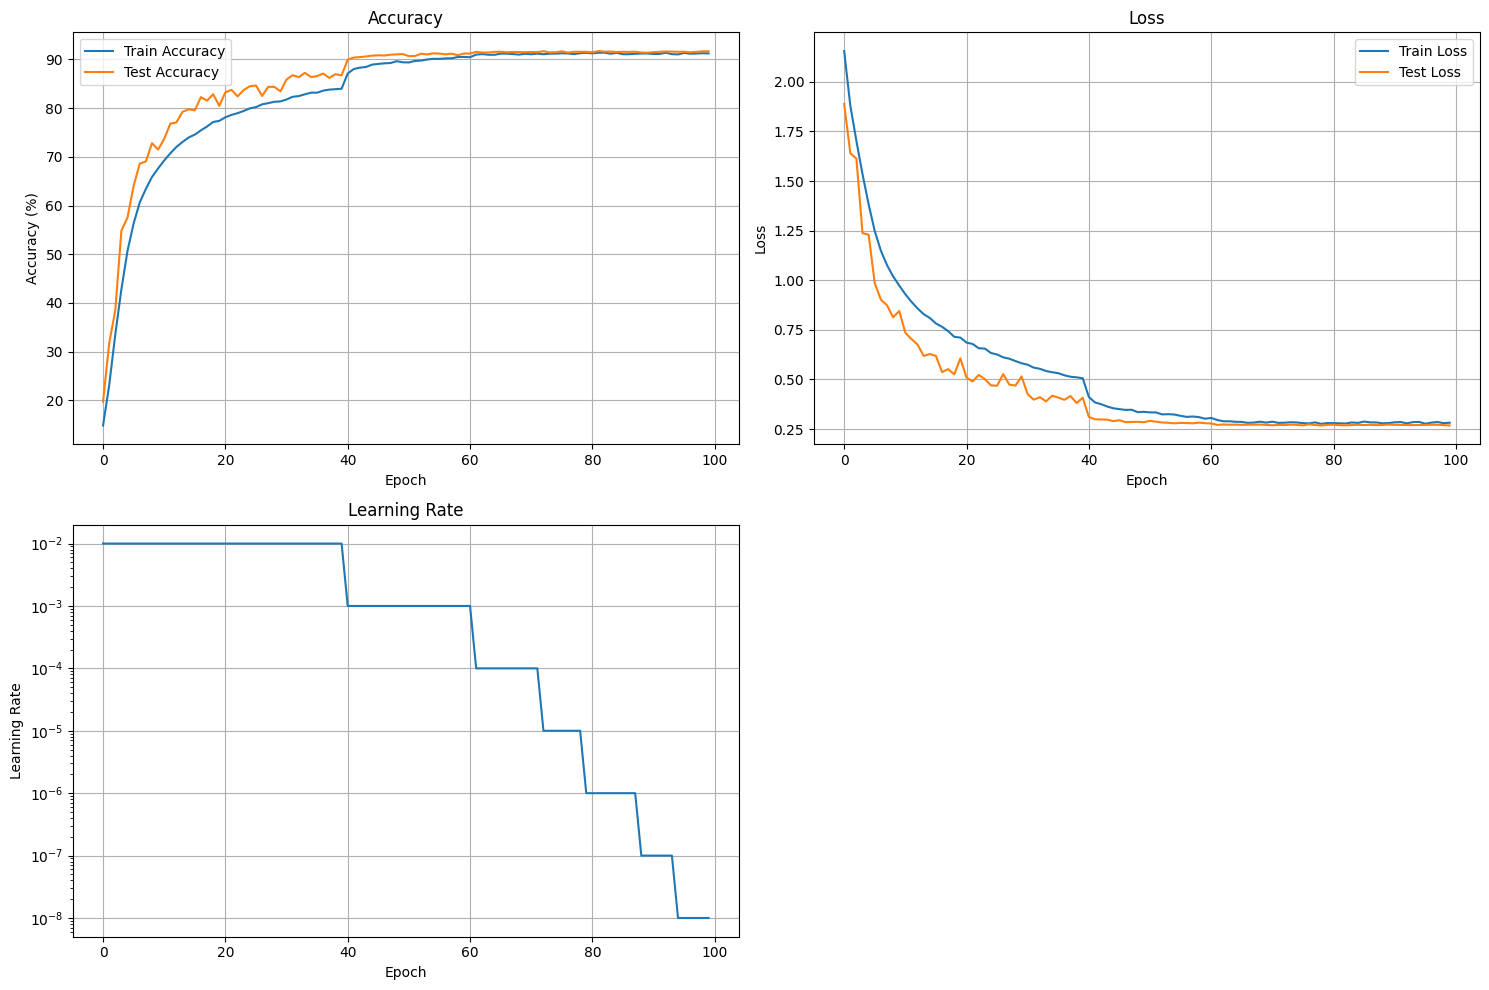


训练结果总结:
最终测试准确率: 91.64%
最佳测试准确率: 91.70%
最佳准确率出现在第 82 轮


In [4]:

# 可视化训练过程
plt.figure(figsize=(15, 10))

# 准确率曲线
plt.subplot(2, 2, 1)
plt.plot(history['train_accs'], label='Train Accuracy')
plt.plot(history['test_accs'], label='Test Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# 损失曲线
plt.subplot(2, 2, 2)
plt.plot(history['train_losses'], label='Train Loss')
plt.plot(history['test_losses'], label='Test Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 学习率变化曲线
plt.subplot(2, 2, 3)
plt.plot(history['lrs'])
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.yscale('log')
plt.grid(True)

plt.tight_layout()
plt.savefig('vgg13_training_with_augmentation.png')
plt.show()

# 输出最终结果
final_test_acc = history['test_accs'][-1]
best_test_acc = max(history['test_accs'])
best_epoch = history['test_accs'].index(best_test_acc) + 1

print("\n训练结果总结:")
print(f"最终测试准确率: {final_test_acc:.2f}%")
print(f"最佳测试准确率: {best_test_acc:.2f}%")
print(f"最佳准确率出现在第 {best_epoch} 轮")